# Legal Agent using LangChain, LangFlow, RAG, extraction

Last update: 06.06.2025


In [2]:
from langchain.chat_models import init_chat_model
from langchain_google_genai import GoogleGenerativeAIEmbeddings
from langchain.vectorstores import FAISS
from langchain_community.document_loaders import PyPDFLoader
from langchain_core.documents import Document
from langchain.prompts import PromptTemplate
from langgraph.checkpoint.memory import MemorySaver

from langgraph.graph import START, StateGraph
from typing_extensions import List, TypedDict
from collections import defaultdict
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.ticker as ticker
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
plt.style.use('dark_background')

from IPython.display import Image, display, HTML

from dotenv import load_dotenv
load_dotenv()
import os

## Step 1: Define Questions


In [3]:
questions = [
    # Effective Tax Rate and Top-up Tax
    {"category": "Effective Tax Rate and Top-up Tax", "question": "What is the reported effective tax rate (ETR)?"},
    {"category": "Effective Tax Rate and Top-up Tax", "question": "Are there jurisdictions where the ETR falls below 15%?"},
    {"category": "Effective Tax Rate and Top-up Tax", "question": "Is the GloBE ETR (or a close approximation) disclosed or estimable from the data?"},
    {"category": "Effective Tax Rate and Top-up Tax", "question": "Has the company disclosed any top-up tax payments, accruals, or provisions related to Pillar Two compliance?"},
    {"category": "Effective Tax Rate and Top-up Tax", "question": "Are low-tax jurisdictions material in terms of revenue or profit contribution?"},
    {"category": "Effective Tax Rate and Top-up Tax", "question": "Are there reconciliations between statutory and effective tax rates, including permanent differences?"},
    {"category": "Effective Tax Rate and Top-up Tax", "question": "Are there large permanent differences or uncertain tax positions that lower the ETR despite high nominal tax rates?"},

    # Geographic Profit Allocation
    {"category": "Geographic Profit Allocation", "question": "How are profits, revenues, and tax expenses distributed across major jurisdictions?"},
    {"category": "Geographic Profit Allocation", "question": "What proportion of earnings is generated in the U.S. versus foreign countries?"},
    {"category": "Geographic Profit Allocation", "question": "How much income tax expense is paid in the U.S. compared to foreign jurisdictions?"},
    {"category": "Geographic Profit Allocation", "question": "Are there significant changes in profit or tax expense allocation by country compared to prior years?"},
    {"category": "Geographic Profit Allocation", "question": "Is there evidence of reduced profits reported in known tax havens (e.g., Ireland, Bermuda, Singapore)?"},
    {"category": "Geographic Profit Allocation", "question": "Have intangible assets or intellectual property been relocated across jurisdictions?"},
    {"category": "Geographic Profit Allocation", "question": "Do tax footnotes disclose any changes in cost-sharing arrangements, IP ownership, or principal entity structures?"},

    # Deferred Taxes and Tax Assets
    {"category": "Deferred Taxes and Tax Assets", "question": "Have there been changes in recognition or valuation of deferred tax assets (DTAs) or liabilities (DTLs) related to Pillar Two?"},
    {"category": "Deferred Taxes and Tax Assets", "question": "Are DTAs in low-tax jurisdictions at risk of derecognition due to minimum tax requirements?"},
    {"category": "Deferred Taxes and Tax Assets", "question": "Do disclosures explain interactions with Qualified Domestic Minimum Top-up Tax (QDMTT) or other GloBE rules?"},
    {"category": "Deferred Taxes and Tax Assets", "question": "Has the company reported impairments or write-downs of DTAs in response to the new tax regime?"},
    {"category": "Deferred Taxes and Tax Assets", "question": "Are any timing differences expected to reverse into top-up tax liabilities?"},

    # Tax Incentives and Credits
    {"category": "Tax Incentives and Credits", "question": "Has the company disclosed changes in the use of tax incentives, credits, or holidays due to Pillar Two?"},
    {"category": "Tax Incentives and Credits", "question": "Are there disclosures about the loss, limitation, or modification of tax benefits under the new rules?"},
    {"category": "Tax Incentives and Credits", "question": "Are GILTI/FDII incentives still being utilized, and how do they interact with GloBE calculations?"},
    {"category": "Tax Incentives and Credits", "question": "Are R&D credits still effective under Pillar Two (e.g., refundable, excluded, or subject to recalculation)?"},
    {"category": "Tax Incentives and Credits", "question": "Is there any discussion of alternative incentive strategies, such as switching to domestic subsidies?"},

    # Compliance and Reporting
    {"category": "Compliance and Reporting", "question": "Has the company disclosed new compliance activities, such as preparation for the GloBE Information Return?"},
    {"category": "Compliance and Reporting", "question": "Are there references to ERP or system changes, internal control updates, or automation for Pillar Two tracking?"},
    {"category": "Compliance and Reporting", "question": "Has the company engaged in lobbying, submitted comment letters, or participated in industry consultations on Pillar Two?"},
    {"category": "Compliance and Reporting", "question": "Are there any new governance or tax risk management structures mentioned in relation to Pillar Two?"},
    {"category": "Compliance and Reporting", "question": "Is country-by-country reporting (CbCR) aligned with GloBE data requirements?"},

    # Qualitative Disclosures
    {"category": "Qualitative Disclosures", "question": "Does management discuss Pillar Two’s impact on strategy, operations, supply chains, or future outlook?"},
    {"category": "Qualitative Disclosures", "question": "Is Pillar Two listed as a material risk in the “Risk Factors” section?"},
    {"category": "Qualitative Disclosures", "question": "Are there mentions of ongoing or potential disputes with tax authorities related to Pillar Two?"},
    {"category": "Qualitative Disclosures", "question": "Does management signal future restructuring plans, such as IP relocation or legal entity changes?"},
    {"category": "Qualitative Disclosures", "question": "Are investors warned about compliance cost increases, volatility, or limitations on tax planning?"}
]



q_ids = [f"Q{i+1}" for i in range(len(questions))]
categories = [q["category"] for q in questions]
questions_text = [q["question"] for q in questions]

df = pd.DataFrame({
    "ID": q_ids,
    "Category": categories,
    "Question": questions_text,
    "Alphabet": [None] * len(questions),
    "Microsoft": [None] * len(questions),
    "Nvidia": [None] * len(questions),
}).astype({
    "Alphabet": "object",
    "Microsoft": "object",
    "Nvidia": "object"
}).set_index("ID")

def style_df(df):
    styled = df.style.set_table_styles([
        {'selector': 'table', 'props': [('border', '2px solid gray'), ('border-collapse', 'collapse')]},
        {'selector': 'th, td', 'props': [('border', '1px solid gray')]},
        {'selector': 'th', 'props': [('text-align', 'center')]},
        {'selector': 'th.col0', 'props': [('width', '100px')]},  
        {'selector': 'th.col1', 'props': [('width', '300px')]},  
        {'selector': 'th.col2', 'props': [('width', '300px')]}, 
        {'selector': 'th.col3', 'props': [('width', '300px')]}, 
        {'selector': 'th.col4', 'props': [('width', '300px')]},  
        {'selector': 'td', 'props': [('text-align', 'left')]}
    ]).set_properties()
    return HTML(styled.to_html(escape=False))

display(style_df(df))


,Category,Question,Alphabet,Microsoft,Nvidia
ID,,,,,
Q1,Effective Tax Rate and Top-up Tax,What is the reported effective tax rate (ETR)?,None,None,None
Q2,Effective Tax Rate and Top-up Tax,Are there jurisdictions where the ETR falls below 15%?,None,None,None
Q3,Effective Tax Rate and Top-up Tax,Is the GloBE ETR (or a close approximation) disclosed or estimable from the data?,None,None,None
Q4,Effective Tax Rate and Top-up Tax,"Has the company disclosed any top-up tax payments, accruals, or provisions related to Pillar Two compliance?",None,None,None
Q5,Effective Tax Rate and Top-up Tax,Are low-tax jurisdictions material in terms of revenue or profit contribution?,None,None,None
Q6,Effective Tax Rate and Top-up Tax,"Are there reconciliations between statutory and effective tax rates, including permanent differences?",None,None,None
Q7,Effective Tax Rate and Top-up Tax,Are there large permanent differences or uncertain tax positions that lower the ETR despite high nominal tax rates?,None,None,None
Q8,Geographic Profit Allocation,"How are profits, revenues, and tax expenses distributed across major jurisdictions?",None,None,None
Q9,Geographic Profit Allocation,What proportion of earnings is generated in the U.S. versus foreign countries?,None,None,None


In [4]:
df.columns

Index(['Category', 'Question', 'Alphabet', 'Microsoft', 'Nvidia'], dtype='object')

## Step 2: Load Docs


In [5]:
# File paths per company
files = {
    "Alphabet": "./data/input/2024_GOOG_10-K.pdf",
    "Microsoft": "./data/input/2024_MSFT_10-K.pdf",
    "Nvidia": "./data/input/2024_NVDA_10-K.pdf"
}

# To store page-level chunks for all companies
all_docs = []
char_counts = {}

# Load documents and annotate metadata
for company, file_path in files.items():
    loader = PyPDFLoader(file_path)
    docs = loader.load()

    # Add metadata and collect character counts
    char_counts[company] = []
    for i, doc in enumerate(docs):
        doc.metadata["company"] = company
        doc.metadata["page_number"] = i + 1
        char_counts[company].append(len(doc.page_content))
        all_docs.append(doc)

# Make a DataFrame of character counts
max_pages = max(len(pages) for pages in char_counts.values())
for company in char_counts:
    char_counts[company] += [pd.NA] * (max_pages - len(char_counts[company]))

df_pages = pd.DataFrame(char_counts).astype("Int64")
df_pages.index = df_pages.index + 1
df_pages.index.name = "Page Number"

# Show the first few rows
display(df_pages)
print(df_pages.sum(), df_pages.count())

# Show a sample document chunk and its metadata
sample_doc = all_docs[0]
print("\nFirst 500 characters of content:")
print(sample_doc.page_content[:500])


,Alphabet,Microsoft,Nvidia
Page Number,,,
1,2760,4222,4950
2,3314,1932,1373
3,1444,4018,4011
4,3782,4266,5785
5,4789,4322,5118
...,...,...,...
164,<NA>,969,<NA>
165,<NA>,3607,<NA>
166,<NA>,4382,<NA>


Alphabet     355077
Microsoft    524209
Nvidia       500606
dtype: Int64 Alphabet      99
Microsoft    168
Nvidia       130
dtype: int64

First 500 characters of content:
UNITED STATES
SECURITIES AND EXCHANGE COMMISSION
Washington, D.C. 20549
___________________________________________
FORM 10-K 
___________________________________________
(Mark One)
☒ ANNUAL REPORT PURSUANT TO SECTION 13 OR 15(d) OF THE SECURITIES EXCHANGE ACT OF 1934
For the fiscal year ended December 31, 2024 
OR
☐ TRANSITION REPORT PURSUANT TO SECTION 13 OR 15(d) OF THE SECURITIES EXCHANGE ACT OF 1934
For the transition period from              to             .
Commission file number: 001-375


In [6]:
# Collect metadata for each company
metadata_dict = defaultdict(dict)

# Use first document from each company as representative
for company in files.keys():
    for doc in all_docs:
        if doc.metadata.get("company") == company:
            for key, value in doc.metadata.items():
                metadata_dict[key][company] = value
            break  # Only take the first doc for metadata sample

# Convert to DataFrame for display
metadata_df = pd.DataFrame(metadata_dict).T
metadata_df.index.name = "Metadata Key"
metadata_df.columns.name = "Company"

# Display nicely
display(metadata_df)

Company,Alphabet,Microsoft,Nvidia
Metadata Key,,,
producer,Wdesk Fidelity Content Translations Version 01...,KS - PDF Engine v1.2,EDGRpdf Service w/ EO.Pdf 22.0.40.0
creator,Workiva,Chromium,EDGAR Filing HTML Converter
creationdate,2025-02-05T12:22:02+00:00,2024-07-30T20:15:26+00:00,2025-02-26T16:49:22-05:00
moddate,2025-02-05T12:22:02+00:00,2024-07-30T20:15:31+00:00,2025-02-26T16:49:44-05:00
title,GOOG 10-K 2024,Form 10-K for Microsoft Corp filed 07/30/2024,0001045810-25-000023
author,anonymous,Kaleidoscope - kscope.io,"EDGAR® Online LLC, a subsidiary of OTC Markets..."
source,./data/input/2024_GOOG_10-K.pdf,./data/input/2024_MSFT_10-K.pdf,./data/input/2024_NVDA_10-K.pdf
total_pages,99,168,130
page,0,0,0


## Step 3: Embed Using Selected Embedding Model


In [7]:
embeddings = GoogleGenerativeAIEmbeddings(model="models/embedding-001")
print(embeddings.model)

models/embedding-001


## Step 4: Store Using Selected Vector Store

In [ ]:
# Skip this step if you have already created a local vectore store

# Create FAISS vector store from your documents and embeddings
vector_store = FAISS.from_documents(all_docs, embeddings)

# Save the vector store locally (folder "faiss_index")
vector_store.save_local("faiss_index")

# Get document IDs (these are internal IDs assigned by FAISS wrapper)
ids = vector_store.docstore._dict.keys()
print(f"Number of IDs: {len(ids)}")
print(f"Sample IDs: {list(ids)[:4]}")

# Retrieve document by ID (example)
doc_id = list(ids)[0]
doc = vector_store.docstore.search(doc_id)
print(doc)


Number of IDs: 397
Sample IDs: ['8858c90b-1c43-417b-95ff-f18d11a58406', 'dca6df06-05e3-46d0-978b-54085aba24a6', '6962f75c-1559-49c6-8910-94706ca9761d', '48d1ec96-6e95-4684-8ae4-906c06a34aec']
page_content='UNITED STATES
SECURITIES AND EXCHANGE COMMISSION
Washington, D.C. 20549
___________________________________________
FORM 10-K 
___________________________________________
(Mark One)
☒ ANNUAL REPORT PURSUANT TO SECTION 13 OR 15(d) OF THE SECURITIES EXCHANGE ACT OF 1934
For the fiscal year ended December 31, 2024 
OR
☐ TRANSITION REPORT PURSUANT TO SECTION 13 OR 15(d) OF THE SECURITIES EXCHANGE ACT OF 1934
For the transition period from              to             .
Commission file number: 001-37580 
___________________________________________
Alphabet Inc. 
(Exact name of registrant as specified in its charter)
___________________________________________
Delaware 61-1767919
(State or other jurisdiction of incorporation or organization) (I.R.S. Employer Identification No.)
1600 Amphith

In [ ]:
doc_id = list(vector_store.docstore._dict.keys())[0]
doc = vector_store.docstore._dict[doc_id]
print(doc.metadata)

page_content='UNITED STATES
SECURITIES AND EXCHANGE COMMISSION
Washington, D.C. 20549
___________________________________________
FORM 10-K 
___________________________________________
(Mark One)
☒ ANNUAL REPORT PURSUANT TO SECTION 13 OR 15(d) OF THE SECURITIES EXCHANGE ACT OF 1934
For the fiscal year ended December 31, 2024 
OR
☐ TRANSITION REPORT PURSUANT TO SECTION 13 OR 15(d) OF THE SECURITIES EXCHANGE ACT OF 1934
For the transition period from              to             .
Commission file number: 001-37580 
___________________________________________
Alphabet Inc. 
(Exact name of registrant as specified in its charter)
___________________________________________
Delaware 61-1767919
(State or other jurisdiction of incorporation or organization) (I.R.S. Employer Identification No.)
1600 Amphitheatre Parkway 
Mountain View, CA 94043 
(Address of principal executive offices, including zip code)
(650) 253-0000 
(Registrant's telephone number, including area code)
Securities registered 

In [9]:
# Reload After Restart
vector_store = FAISS.load_local("faiss_index", embeddings, allow_dangerous_deserialization=True)

## Step 5: Retrieve Using Selected LLM/SLM

-----
Custom Prompt:
 You are a legal assistant. 
    Answer the question using only the information provided in the context. 
    Quote or copy the exact relevant text from the context, 
    providing the page number in brackets like (p. 1). 
    If the answer is not present, reply "Not in context."
Question: {question}
Context: {context}
Answer:


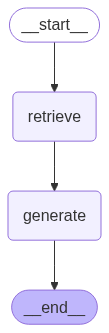

In [10]:
custom_prompt = PromptTemplate(
    input_variables=["context", "question"],
    template="""You are a legal assistant. 
    Answer the question using only the information provided in the context. 
    Quote or copy the exact relevant text from the context, 
    providing the page number in brackets like (p. 1). 
    If the answer is not present, reply "Not in context."
Question: {question}
Context: {context}
Answer:"""
)
print("-----\nCustom Prompt:\n", custom_prompt.template)

llm = init_chat_model("gemini-2.0-flash", model_provider="google_genai")

# Define state type
class State(TypedDict):
    question: str
    context: List[Document]
    company: str
    answer: str

# Filter vector store by company
def retrieve(state: State):
    retrieved_docs = vector_store.similarity_search(
        state["question"],
        k=8*3
    )
        #filter=lambda doc: doc.metadata.get("company") == state["company"]
    filtered_docs = [
        doc for doc in retrieved_docs
        if doc.metadata.get("company") == state["company"]
    ]
    return {
        **state,
        "context": filtered_docs[:8]  
    }

# Inject page_number explicitly into context
def generate(state: State):
    docs_content = "\n\n".join(
        f"[Page {doc.metadata.get('page_number', '?')}] {doc.page_content}"
        for doc in state["context"]
    )
    messages = custom_prompt.invoke({
        "question": state["question"],
        "context": docs_content
    })
    response = llm.invoke(messages)
    return {
        **state,
        "answer": response.content  # ✅ Preserve context/company/question
    }

# Build state graph
graph_builder = StateGraph(State).add_sequence([retrieve, generate])
graph_builder.add_edge(START, "retrieve")
graph = graph_builder.compile()

# Visualize graph
display(Image(graph.get_graph().draw_mermaid_png(
    background_color="transparent",
    output_file_path="./data/output/langgraph.png"
)))

In [11]:
question = "What is the reported effective tax rate (ETR), if available?"

for company in ["Alphabet", "Microsoft", "Nvidia"]:
    print(f"\n🔎 {company}")
    result = graph.invoke({"question": question, "company": company})
    print(result["answer"])


🔎 Alphabet
The reported effective tax rates (ETR) are:
*   2023: 13.9%
*   2024: 16.4% (p. 40)

🔎 Microsoft
The reported effective tax rates are:
*   2024: 18.2% (p. 82)
*   2023: 19.0% (p. 82)
*   2022: 13.1% (p. 82)

Also, "Our effective tax rate for fiscal years 2024 and 2023 was 18% and 19%, respectively." (p. 47)

🔎 Nvidia
The effective tax rate for fiscal years 2025 and 2024 was 13.3% and 12.0%, respectively (p. 43).


In [25]:
print(df.columns)
print(q_ids[0])
print(df.at[q_ids[0], "Alphabet"])


Index(['Category', 'Question', 'Alphabet', 'Apple', 'Nvidia'], dtype='object')
Q1
Error: Error embedding content: 'ProtoType' object has no attribute 'DESCRIPTOR'


In [24]:
# Loop through all questions and companies
for i, q in enumerate(questions):
    qid = q_ids[i]
    question_text = q["question"]
    print(f"\n🔎 [{qid}] {q["category"]}: {q["question"]}")
    
    for company in ["Alphabet", "Microsoft", "Nvidia"]:
        
        try:
            result = graph.invoke({"question": question_text, "company": company})
            answer = result["answer"]
            print(f"  📄 {company}: {result["answer"]}")
        except Exception as e:
            answer = f"Error: {e}"
        
        df.at[qid, company] = answer

display(style_df(df))



🔎 [Q1] Effective Tax Rate and Top-up Tax: What is the reported effective tax rate (ETR)?
  📄 Alphabet: The reported effective tax rates (ETR) are:
*   2023: 13.9 % (p. 40, 86)
*   2024: 16.4 % (p. 40, 86)
*   2022: 15.9 % (p. 86)
  📄 Microsoft: The reported effective tax rates (ETR) are:
*   2024: 18.2% (p. 82) or 18% (p. 47)
*   2023: 19.0% (p. 82) or 19% (p. 47)
*   2022: 13.1% (p. 82)
  📄 Nvidia: "Income tax as a percentage of income before income tax was an expense of 13.3% and 12.0% for fiscal years 2025 and 2024, respectively." (p. 43)

🔎 [Q2] Effective Tax Rate and Top-up Tax: Are there jurisdictions where the ETR falls below 15%?
  📄 Alphabet: Yes, based on the provided data, there are jurisdictions where the ETR falls below 15%. In 2023, the effective tax rate was 13.9% (p. 86).
  📄 Microsoft: "The Organisation for Economic Co-operation and Development (“OECD”) published its model rules “Tax Challenges Arising From the Digitalisation of the Economy - Global Anti-Base Erosion 

,Category,Question,Alphabet,Microsoft,Nvidia
ID,,,,,
Q1,Effective Tax Rate and Top-up Tax,What is the reported effective tax rate (ETR)?,"The reported effective tax rates (ETR) are: * 2023: 13.9 % (p. 40, 86) * 2024: 16.4 % (p. 40, 86) * 2022: 15.9 % (p. 86)",The reported effective tax rates (ETR) are: * 2024: 18.2% (p. 82) or 18% (p. 47) * 2023: 19.0% (p. 82) or 19% (p. 47) * 2022: 13.1% (p. 82),"""Income tax as a percentage of income before income tax was an expense of 13.3% and 12.0% for fiscal years 2025 and 2024, respectively."" (p. 43)"
Q2,Effective Tax Rate and Top-up Tax,Are there jurisdictions where the ETR falls below 15%?,"Yes, based on the provided data, there are jurisdictions where the ETR falls below 15%. In 2023, the effective tax rate was 13.9% (p. 86).","""The Organisation for Economic Co-operation and Development (“OECD”) published its model rules “Tax Challenges Arising From the Digitalisation of the Economy - Global Anti-Base Erosion Model Rules (Pillar Two)” which established a global minimum corporate tax rate of 15% for certain multinational enterprises."" (p. 47) It is implied that there are jurisdictions where the ETR falls below 15%, because the OECD established a *minimum* corporate tax rate of 15%.",Not in context.
Q3,Effective Tax Rate and Top-up Tax,Is the GloBE ETR (or a close approximation) disclosed or estimable from the data?,Not in context.,Not in context.,Not in context.
Q4,Effective Tax Rate and Top-up Tax,"Has the company disclosed any top-up tax payments, accruals, or provisions related to Pillar Two compliance?",Not in context.,"""Many countries have implemented or are in the process of implementing the Pillar Two legislation, which will apply to Microsoft beginning in fiscal year 2025. While we do not currently estimate a material impact to our consolidated financial statements, we continue to monitor the impact as countries implement legislation and the OECD provides additional guidance."" (p. 47)",Not in context.
Q5,Effective Tax Rate and Top-up Tax,Are low-tax jurisdictions material in terms of revenue or profit contribution?,Not in context.,"The context indicates that earnings taxed at lower rates in foreign jurisdictions are material in terms of revenue or profit contribution: * In fiscal years 2024 and 2023, the foreign regional operating center in Ireland, which is taxed at a rate lower than the U.S. rate, generated 83% and 81% of our foreign income before tax, respectively (p. 82). * In fiscal year 2022, the foreign regional operating centers in Ireland and Puerto Rico, which are taxed at rates lower than the U.S. rate, generated 71% of our foreign income before tax (p. 82).",Not in context.
Q6,Effective Tax Rate and Top-up Tax,"Are there reconciliations between statutory and effective tax rates, including permanent differences?","Yes, there are reconciliations between statutory and effective tax rates, including permanent differences. ""The reconciliation of federal statutory income tax rate to our effective income tax rate was as follows:"" (p. 86). The table following this statement shows the reconciliation, which includes items such as ""Foreign income taxed at different rates,"" ""Foreign-derived intangible income deduction,"" and ""Stock-based compensation expense"" (p. 86).","Yes, there are reconciliations between statutory and effective tax rates. The text states, ""The items accounting for the difference between income taxes computed at the U.S. federal statutory rate and our effective rate were as follows"" (p. 82). The table provided lists various items that contribute to this difference, such as ""Foreign earnings taxed at lower rates,"" ""State income taxes, net of federal benefit,"" and ""Other reconciling items, net"" (p. 82). The reconciliation includes permanent differences.","Yes, there is a reconciliation between the statutory and effective tax rates, including permanent differences. The text states, ""The income tax expense (benefit) differs from the amount 

In [29]:
# Save the results
#df.to_excel("./data/output/10-K_GOOG_MSFT_NVDA.xlsx")

# Load on restart
#df = pd.read_excel("./data/output/10-K_GOOG_MSFT_NVDA.xlsx")
#df.set_index("ID", inplace=True)
#df.tail()

## Step 6: Report Generation with Memory

In [17]:
report_questions = ["Summarize the findings in the dataframe in the view of Pillar Two reform.",
                    "Formulate the answer to the previous questions using coherent text passages. Each sentence should include APA style of citation with year 2024 and page number, e.g. (Apple Inc., 2024, p. 10)",
                    "Has the company acknowledged Pillar Two as a material risk or disclosed any strategic or structural changes in anticipation of compliance requirements?",
                    "Are there any jurisdictions where the reported effective tax rate (ETR) falls below 15%, and has the company commented on potential top-up tax implications?",
                    "Has the company reported any changes in deferred tax assets or liabilities due to the introduction of global minimum tax rules?",
                    "Is there evidence of significant changes in geographic profit or tax allocation compared to prior years, especially in low-tax jurisdictions?"]


report_prompt = PromptTemplate(
    input_variables=["history", "question", "dataframe"],
    template="""You are a financial analyst assistant writing a concise, insightful report.

You are given a DataFrame (formatted as a table) and a running conversation history.

Use the data and context to answer each question helpfully. Be concise but informative.

Refer to specific company names or metrics from the data.

Conversation history:
{history}

DataFrame:
{dataframe}

Question: {question}
Answer:"""
)


class ReportState(TypedDict):
    question: str
    dataframe: str
    history: str  # past Q&As
    answer: str


def generate_report(state: ReportState):
    messages = report_prompt.invoke({
        "question": state["question"],
        "history": state["history"],
        "dataframe": state["dataframe"]
    })
    response = llm.invoke(messages)
    
    # Append Q&A to history
    updated_history = (
        state["history"]
        + f"\nQ: {state['question']}\nA: {response.content.strip()}\n"
    )

    return {
        "question": state["question"],
        "history": updated_history,
        "dataframe": state["dataframe"],
        "answer": response.content.strip()
    }


# Set up memory
report_memory = MemorySaver()

# Build graph
report_builder = StateGraph(ReportState).add_node("generate", generate_report)
report_builder.set_entry_point("generate")
report_graph = report_builder.compile(checkpointer=report_memory)

# Convert df to markdown string (once)
df_markdown = df.to_markdown()

# Set memory-backed config
config = {"configurable": {"thread_id": "report_3_bigtech"}}

# Start with empty history
history = ""

# First question
first_question = report_questions[0]
first_input = {
    "question": first_question,
    "dataframe": df_markdown,
    "history": history
}

# Run the first question
result = report_graph.invoke(config=config, input=first_input)
print(f"Q: {first_question}\nA: {result['answer']}\n{'-'*50}")
history = result["history"]

Q: Summarize the findings in the dataframe in the view of Pillar Two reform.
A: Here's a summary of the findings related to Pillar Two reform, based on the provided data:

*   **Effective Tax Rate (ETR):** All three companies have reported ETRs that sometimes fall below 15% in certain jurisdictions (Q2).
*   **Top-up Tax:** Microsoft states Pillar Two will apply to them beginning in fiscal year 2025. While they don't currently estimate a material impact, they are monitoring the situation (Q4, Q30).
*   **Low-Tax Jurisdictions:** Microsoft's foreign regional operating center in Ireland, which is taxed at a lower rate than the U.S., generated a significant portion of their foreign income before tax (83% in 2024, 81% in 2023) (Q5, Q12).
*   **Reconciliations:** All three companies provide reconciliations between statutory and effective tax rates, including permanent differences (Q6).
*   **Uncertain Tax Positions:** Alphabet and Microsoft have significant gross unrecognized tax benefits r

In [18]:
q2 = report_questions[1]
input2 = {
    "question": q2,
    "dataframe": df_markdown,
    "history": history
}
result2 = report_graph.invoke(config=config, input=input2)
print(f"Q: {q2}\nA: {result2['answer']}\n{'-'*50}")
history = result2["history"]

Q: Formulate the answer to the previous questions using coherent text passages. Each sentence should include APA style of citation with year 2024 and page number, e.g. (Apple Inc., 2024, p. 10)
A: Here's a summary of the findings related to Pillar Two reform, presented in coherent text passages with APA-style citations:

**Effective Tax Rate and Top-up Tax:** All three companies reported effective tax rates (ETRs) (Alphabet Inc., 2024, p. 40, 86; Microsoft Corporation, 2024, p. 82; Nvidia Corporation, 2024, p. 43). Alphabet's ETRs were 13.9% (2024, p. 86), 16.4% (2024, p. 86), and 15.9% (2024, p. 86). Microsoft's ETRs ranged from 13.1% to 19.0% (2024, p. 82). Nvidia's ETRs were 12.0% and 13.3% (2024, p. 43). All three companies provide reconciliations between statutory and effective tax rates, including permanent differences (Alphabet Inc., 2024, p. 86; Microsoft Corporation, 2024, p. 82; Nvidia Corporation, 2024, p. 75).

**Pillar Two Impact:** Microsoft stated that Pillar Two will ap

In [19]:
#result2["history"]

In [20]:
# Iterate over the remaining questions
for q in report_questions[2:]:
    input_data = {
        "question": q,
        "dataframe": df_markdown,
        "history": history,
    }
    result = report_graph.invoke(config=config, input=input_data)
    print(f"Q: {q}\nA: {result['answer']}\n{'-'*50}")
    history = result["history"]

Q: Has the company acknowledged Pillar Two as a material risk or disclosed any strategic or structural changes in anticipation of compliance requirements?
A: **Pillar Two as a Material Risk:** Nvidia Corporation acknowledges Pillar Two as a risk factor, stating that changes in tax laws may increase tax uncertainty and compliance costs (Nvidia Corporation, 2024, p. 31).

**Strategic or Structural Changes:** Nvidia mentions implementing updated accounting functionality related to a new ERP system (Nvidia Corporation, 2024, p. 24). Microsoft also mentions upgrading their ERP system (Microsoft Corporation, 2024, p. 46). These ERP system updates could be related to Pillar Two tracking.
--------------------------------------------------
Q: Are there any jurisdictions where the reported effective tax rate (ETR) falls below 15%, and has the company commented on potential top-up tax implications?
A: **Jurisdictions with ETR Below 15%:** Alphabet Inc. reported an ETR of 13.9% in 2023 (Alphabet I

## Step 7: Scheme-Based Extraction 

In [46]:
from pydantic import BaseModel, Field
from typing import Optional, List

class TaxData(BaseModel):
    etr_2024: Optional[float] = Field(None, description="Effective tax rate (ETR) for 2024, in percentage.")
    us_tax_2024: Optional[float] = Field(None, description="Total U.S. taxes paid in 2024, including federal and state, in millions USD.")
    foreign_tax_2024: Optional[float] = Field(None, description="Foreign taxes paid in 2024, in millions USD.")

class CompanyTax(BaseModel):
    company: str
    tax_info: TaxData

class TaxExtraction(BaseModel):
    companies: List[CompanyTax]


llm = init_chat_model(model="gemini-2.5-pro-preview-03-25", model_provider="google_genai")

structured_llm = llm.with_structured_output(schema=TaxExtraction)


extraction_prompt = f"""
You are a legal assistant.

From the following 10-K data (formatted as a table), extract for each company:
- Effective tax rate (ETR) for 2024, as a float percentage
- Taxes paid in the U.S. (federal + state), in millions of USD for 2024
- Taxes paid in foreign jurisdictions for 2024, also in millions of USD

Return the result in structured format.

Table:
{df_markdown}
"""

result = structured_llm.invoke(extraction_prompt)
print(result)

companies=[CompanyTax(company='Alphabet', tax_info=TaxData(etr_2024=16.4, us_tax_2024=22485.0, foreign_tax_2024=2468.0)), CompanyTax(company='Microsoft', tax_info=TaxData(etr_2024=18.2, us_tax_2024=14531.0, foreign_tax_2024=9858.0)), CompanyTax(company='Nvidia', tax_info=TaxData(etr_2024=12.0, us_tax_2024=6045.0, foreign_tax_2024=502.0))]


In [47]:
data = [
    {
        "Company": company.company,
        "ETR 2024 (%)": company.tax_info.etr_2024,
        "US Tax 2024 (USD M)": company.tax_info.us_tax_2024,
        "Foreign Tax 2024 (USD M)": company.tax_info.foreign_tax_2024,
    }
    for company in result.companies
]

df_tax_extract = pd.DataFrame(data)

# Step 3: Display
display(df_tax_extract)

,Company,ETR 2024 (%),US Tax 2024 (USD M),Foreign Tax 2024 (USD M)
0,Alphabet,16.4,22485.0,2468.0
1,Microsoft,18.2,14531.0,9858.0
2,Nvidia,12.0,6045.0,502.0


In [48]:
df_tax_extract.to_excel("./data/output/kpi_2024.xlsx")

In [49]:
print(df_tax_extract.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3 entries, 0 to 2
Data columns (total 4 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Company                   3 non-null      object 
 1   ETR 2024 (%)              3 non-null      float64
 2   US Tax 2024 (USD M)       3 non-null      float64
 3   Foreign Tax 2024 (USD M)  3 non-null      float64
dtypes: float64(3), object(1)
memory usage: 228.0+ bytes
None


## Step 8: Visualization

**Effective Tax Rate (ETR) Formula**

$$
\text{ETR} = \frac{\text{Total Income Tax Expense}}{\text{Pre-Tax Income}} \times 100\%
$$

*Where:*
- **Total Income Tax Expense**: Includes federal, state, and foreign taxes.
- **Pre-Tax Income**: Income before any tax is deducted (also called earnings before taxes, or EBT).


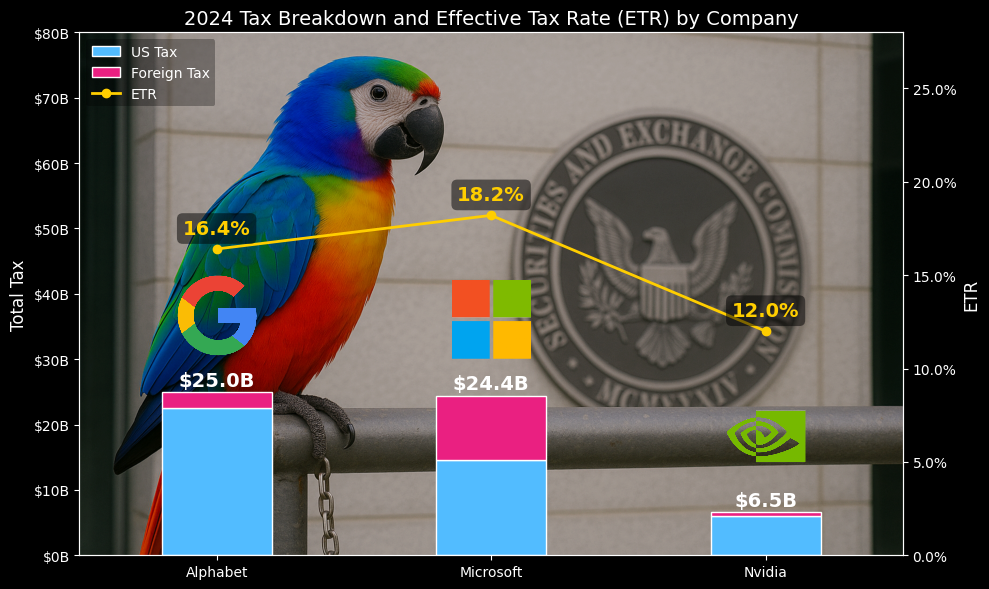

In [62]:
bg_img = mpimg.imread('./assets/gemini-sec.png')

# Prepare data
companies = df_tax_extract["Company"]
us_tax = df_tax_extract["US Tax 2024 (USD M)"]
foreign_tax = df_tax_extract["Foreign Tax 2024 (USD M)"]
etr = df_tax_extract["ETR 2024 (%)"]

us_tax_billion = us_tax / 1000
foreign_tax_billion = foreign_tax / 1000
total_tax_billion = us_tax_billion + foreign_tax_billion

bar_width = 0.4

# Map companies to logos (ensure order matches)
logos = {
    "Nvidia": "./assets/bigtech_NVDA.png",
    "Alphabet": "./assets/bigtech_GOOG.png",
    "Microsoft": "./assets/bigtech_MSFT.png"
}

# Create plot
fig, ax1 = plt.subplots(figsize=(10, 6))

ax1.imshow(
    bg_img,
    extent=[-0.5, 2.5, 0, 80],
    aspect='auto', zorder=0
)
ax1.axhspan(0, 1_400_000, xmin=0, xmax=1, color='black', alpha=0.1, zorder=1)


# Stacked bar chart (total tax)
bars1 = ax1.bar(
    companies, 
    us_tax_billion, 
    label="US Tax", 
    color="#52bcff", 
    width=bar_width, 
    edgecolor="white", 
    linewidth=1
)
bars2 = ax1.bar(
    companies, 
    foreign_tax_billion, 
    bottom=us_tax_billion, 
    label="Foreign Tax", 
    color="#ea2081", 
    width=bar_width, 
    edgecolor="white", 
    linewidth=1
)
ax1.set_ylabel("Total Tax", fontsize=12)
ax1.set_ylim(0, 80)
ax1.set_xlabel("", fontsize=12)
ax1.tick_params(axis='x', rotation=0)
ax1.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f"${x:.0f}B"))

# Create second y-axis for ETR
ax2 = ax1.twinx()
line = ax2.plot(companies, etr, label="ETR", color="#ffce00", marker="o", linewidth=2)
ax2.set_ylabel("ETR", fontsize=12)
ax2.set_ylim(0, 28)
ax2.yaxis.set_major_formatter(ticker.PercentFormatter())

# Annotations for total tax and logos
for i, company in enumerate(companies):
    total = total_tax_billion.iloc[i]
    
    # Total tax label
    ax1.annotate(f"${total:.1f}B", xy=(i, total + 1), ha='center', fontsize=14, fontweight='bold')
    
    # Add logo above bar
    if company in logos:
        try:
            logo = mpimg.imread(logos[company])
            imagebox = OffsetImage(logo, zoom=0.15)
            ab = AnnotationBbox(imagebox, (i, total + 5), frameon=False, box_alignment=(0.5, 0))
            ax1.add_artist(ab)
        except FileNotFoundError:
            print(f"Logo file for {company} not found.")

# Annotate ETR values on the line chart
for i, rate in enumerate(etr):
    ax2.annotate(
        f"{rate:.1f}%", 
        xy=(i, rate + 0.8), 
        ha='center', 
        fontsize=14, 
        color="#ffce00", 
        weight="bold",
        bbox=dict(
            facecolor='black', 
            alpha=0.5,       
            edgecolor='none', 
            boxstyle='round,pad=0.3'
        )
    )

# Legend
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
legend = ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc="upper left", framealpha=0.3)
legend.get_frame().set_linewidth(0.0)

plt.title("2024 Tax Breakdown and Effective Tax Rate (ETR) by Company", fontsize=14)
plt.tight_layout()
plt.savefig("./data/output/tax_etr_2024.png", dpi=300)
plt.show()


# References

- LangChain. Build a Retrieval Augmented Generation (RAG) App: Part 1. https://python.langchain.com/docs/tutorials/rag/
- LangChain. Build a Retrieval Augmented Generation (RAG) App: Part 2. https://python.langchain.com/docs/tutorials/qa_chat_history/
- LangChain. Build a semantic search engine. https://python.langchain.com/docs/tutorials/retrievers/

